In [1]:
import yfinance as yf
import pandas   as pd
import numpy    as np


In [2]:
def backtester(signals,price, tcost = 0.005):

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1

        for i,val in enumerate(price):

            if i == len(price)-1:
                break


            if signals[i] == 0:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0


        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        return pd.DataFrame(returns, index = price.index)
    
def win_rate(sigs, returns):
    
    """
    Signals : series
    returns : series
    must be same length
    """
    
    tps = []

    sigs = sigs[1:-1].values.ravel()

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()

    for i,val in enumerate(sigs):

        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)

    win_rate = sum(tps)/len(sigs)
    return win_rate

def max_dd(returns, window=None):

    data = (1+pd.Series(returns)).cumprod()

    if window is not None:
        roll_max = data.rolling(window, min_periods=1).max()
    else:
        roll_max = data.expanding().max()

    daily = data/roll_max - 1.0

    return min(daily)

In [3]:
btc = yf.Ticker("BTC-USD").history(period="30y",interval = '1wk')

btc_levels = btc['Close'].copy()
btc_levels

Date
2014-09-15      398.821014
2014-09-22      377.181000
2014-09-29      320.510010
2014-10-06      378.549011
2014-10-13      389.545990
                  ...     
2022-08-01    23175.890625
2022-08-08    24319.333984
2022-08-15    21534.121094
2022-08-22    21398.908203
2022-08-23    21506.773438
Name: Close, Length: 416, dtype: float64

In [4]:
def rsi_tradingview(ohlc: pd.DataFrame, period: int = 14, round_rsi: bool = True):
    """ 
    From : https://github.com/lukaszbinden/rsi_tradingview/blob/main/rsi.py
    Implements the RSI indicator as defined by TradingView on March 15, 2021.
    The TradingView code is as follows:
    //@version=4
    study(title="Relative Strength Index", shorttitle="RSI", format=format.price, precision=2, resolution="")
    len = input(14, minval=1, title="Length")
    src = input(close, "Source", type = input.source)
    up = rma(max(change(src), 0), len)
    down = rma(-min(change(src), 0), len)
    rsi = down == 0 ? 100 : up == 0 ? 0 : 100 - (100 / (1 + up / down))
    plot(rsi, "RSI", color=#8E1599)
    band1 = hline(70, "Upper Band", color=#C0C0C0)
    band0 = hline(30, "Lower Band", color=#C0C0C0)
    fill(band1, band0, color=#9915FF, transp=90, title="Background")
    :param ohlc:
    :param period:
    :param round_rsi:
    :return: an array with the RSI indicator values
    """

    delta = ohlc.diff()

    up = delta.copy()
    up[up < 0] = 0
    up = pd.Series.ewm(up, alpha=1/period).mean()

    down = delta.copy()
    down[down > 0] = 0
    down *= -1
    down = pd.Series.ewm(down, alpha=1/period).mean()

    rsi = np.where(up == 0, 0, np.where(down == 0, 100, 100 - (100 / (1 + up / down))))

    return np.round(rsi, 2) if round_rsi else rsi

<AxesSubplot:xlabel='Date'>

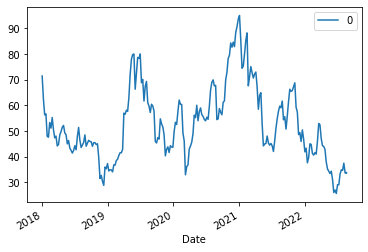

In [5]:
RSI = pd.DataFrame(rsi_tradingview(btc_levels),index = btc_levels.index)['2018-01-1':]

RSI.plot()

In [14]:

signals = []

for i in RSI.values.ravel():
    if i > 52:
        signals.append(1)
    if i < 52:
        signals.append(0)



In [16]:
returns = backtester(pd.Series(signals),btc_levels['2018-01-01':])
dd = max_dd(returns.pct_change().dropna().values.ravel())
wr = win_rate(pd.Series(signals), returns)

-0.6048048016852245

0.2396694214876033

<AxesSubplot:xlabel='Date'>

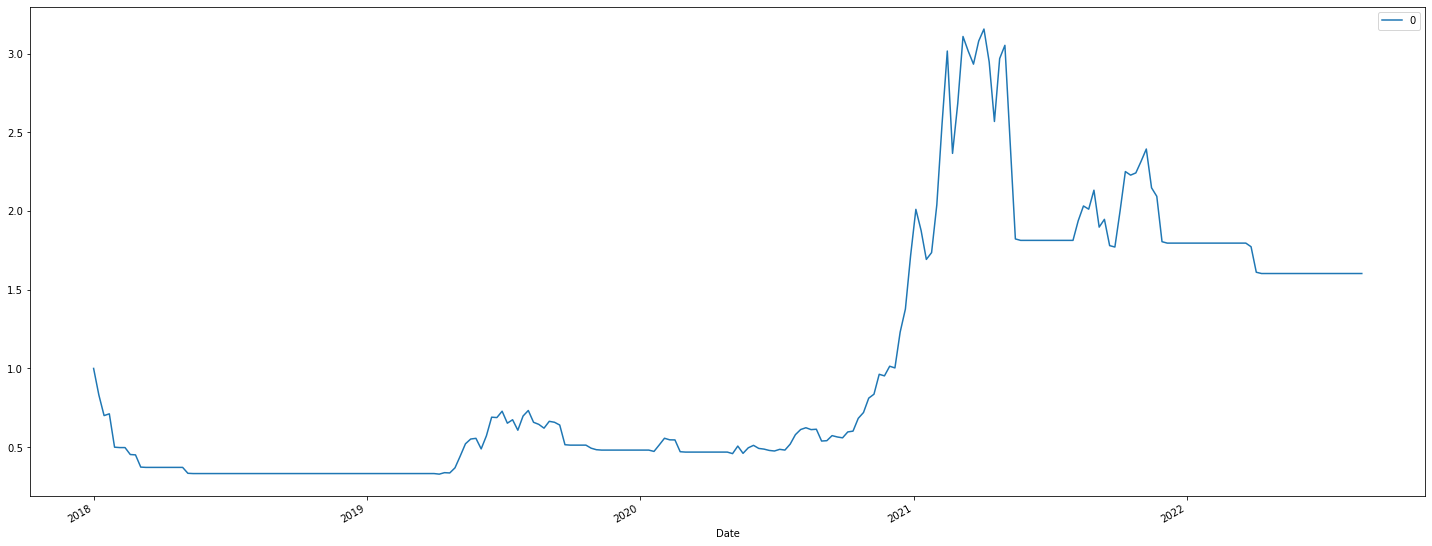

In [18]:
display(dd)
display(wr)
returns.plot(figsize = (25,10))